**Perspective Correction for Field Images**

Unlike lab images, field images are likely to have a warped perspective. Perspective correction will be necessary to capture the isolated wing and calculate appropriate wing length calculations.

This algorithm depends on Aruco markers to identify the warping. Additionally, as Aruco markers are oriented with a top and bottom, the wing must be captured within correctly oriented Aruco markers. The wing should be placed above the arrow in the bottom right hand corner of the marker card.

Below is an example of the Aruco marker card and a warped field image (without Aruco markers). Future field images will include the Aruco markers.

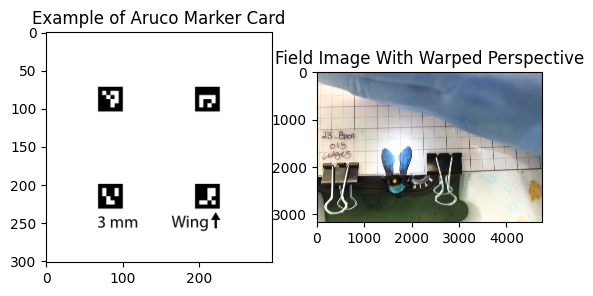

In [21]:
import cv2
import matplotlib.pyplot as plt
marker_card = cv2.imread("/notebook_images/arcuo_marker_card.png")
field_image = cv2.imread("/notebook_images/IMG_3211.JPG")
plt.subplot(121),plt.imshow(marker_card),plt.title('Example of Aruco Marker Card')
plt.subplot(122),plt.imshow(field_image),plt.title('Field Image With Warped Perspective')
plt.show()

Once the Aruco markers in the image are identified, the image perspective is corrected, then the final output image is cropped along the outer corners of the Aruco markers.

Input image folder path:  /Users/dannahgolich/Desktop/PSTAT197/module_2_clone/capstone-CCBER/perspective_correction/warp_test


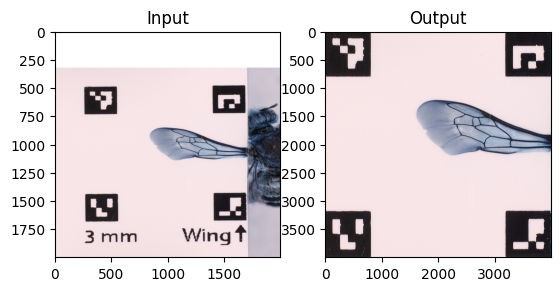

error correcting image: .DS_Store
OpenCV(4.9.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'



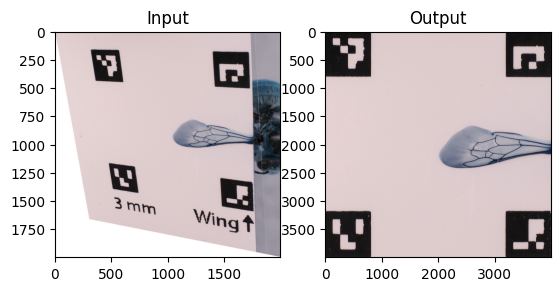

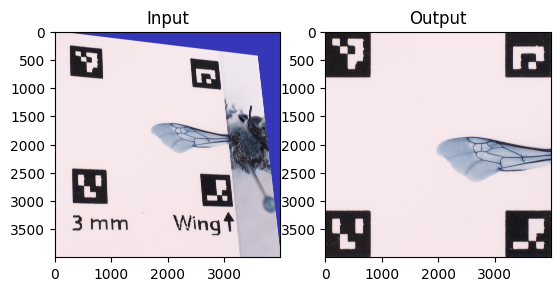

In [31]:
# import packages
import numpy as np
import os

def detect_markers(image):
    '''detects Aruco markers and returns an array of the coordinates of each marker's corners'''
    # Load ARUCO dictionary
    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)

    # Initialize ARUCO parameters
    parameters = cv2.aruco.DetectorParameters()

    # Create ArucoDetector
    detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

    # Detect markers
    corners, _, _ = detector.detectMarkers(image) # only need corner output

    return corners

def detect_outer_corners(corners):
    '''detects the outer corners of the Aruco markers to crop the image and transform the perspective'''
    # obtain sums of each corner coordinates
    corners_list = [np.sum(array) for array in corners]

    #top left Aruco marker will have the smallest coordinate sum and bottom right will have the largest coordinate sum
    top_left_index = corners_list.index(min(corners_list))
    bottom_right_index = corners_list.index(max(corners_list))

    # obtain other indexes not identified
    # ARUCO does not identify the markers in a specific order
    number_list = [i for i in range(0,4)]
    not_in_list = [item for item in number_list if item not in [top_left_index, bottom_right_index]]

    # compare the x coordinates of the top left corners of remaining Aruco markers
    # smaller x coordinate identifies bottom left marker
    # larger x coordinate identifies top right marker
    if corners[not_in_list[0]][0][0][0] > corners[not_in_list[1]][0][0][0]:
        top_right_index = not_in_list[0]
        bottom_left_index = not_in_list[1]
    else:
        top_right_index = not_in_list[1]
        bottom_left_index = not_in_list[0]

    # create an array of the outer corners of each Aruco marker
    outer_corners = np.array([corners[top_left_index][0][0], corners[top_right_index][0][1], corners[bottom_left_index][0][3], corners[bottom_right_index][0][2]])

    return outer_corners

image_folder_path = input("Input image folder path: ")
output_folder_path = os.path.join(image_folder_path, "corrected_images")
# create subfolder for corrected images
if not os.path.isdir(output_folder_path):
    os.mkdir(output_folder_path)

for image_path in os.listdir(image_folder_path):
    # go through each file in the provided folder
    image_file_path = os.path.join(image_folder_path, image_path)
    if os.path.isfile(image_file_path):
        try:
            image = cv2.imread(image_file_path)            
            # Convert image to grayscale
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            # Detect ARUCO markers and find square markers
            corners = detect_markers(gray)
            
            # detect the outer corners of the markers
            outer_corners = detect_outer_corners(corners)
            
            # set cropping coordinates for final picture
            straight_on_coords = np.array([[0, 0], [4000, 0], [0, 4000],[4000, 4000]]) 
            
            # generate perspective transform information 
            perspective_transform = cv2.getPerspectiveTransform(outer_corners.astype(np.float32),straight_on_coords.astype(np.float32))
            
            # correct perspective
            corrected_image = cv2.warpPerspective(image,perspective_transform,(4000,4000))
            
            # compare before and after perspective correction
            plt.subplot(121),plt.imshow(image),plt.title('Input')
            plt.subplot(122),plt.imshow(corrected_image),plt.title('Output')
            plt.show()
            
            # save image
            cv2.imwrite(os.path.join(output_folder_path, f"{image_path.split('.')[0]}_corrected.jpeg"), corrected_image)
        except Exception as e:
            print(f"error correcting image: {image_path}")
            print(e)
    
